In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms

import copy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm




In [2]:
N, D_in, D_out = 1000, 2, 1


# m =1
X2 = []
y2 = []
for j in range(N):
    X2.append([])
    #y.append([])
    for i in range(D_out):
        X2[-1].append( 1 )
        X2[-1].append( np.random.uniform(low=-1000.0, high=1000.0, size=None) )
        y2.append( (X2[-1][-1]**2) / (2*X2[-1][-2])  )


X2 = torch.Tensor(X2)
y2 = torch.Tensor(y2)


# p =1
X3 = []
y3 = []
for j in range(N):
    X3.append([])
    #y.append([])
    for i in range(D_out):
        X3[-1].append( np.random.uniform(low=0.0, high=10.0, size=None) )
        X3[-1].append( 1 )
        y3.append( (X3[-1][-1]**2) / (2*X3[-1][-2])  )


X3 = torch.Tensor(X3)
y3 = torch.Tensor(y3)

# X2_test = torch.tensor(X2, dtype=torch.float32)
# y2_test = torch.tensor(y2, dtype=torch.float32).reshape(-1, 1)
# X3_test = torch.tensor(X3, dtype=torch.float32)
# y3_test = torch.tensor(y3, dtype=torch.float32).reshape(-1, 1)

In [3]:

X = torch.load('/content/drive/MyDrive/0_318lab/SCMP_ML/KEdataX_1000_1690897080.8460803.pt')
y = torch.load('/content/drive/MyDrive/0_318lab/SCMP_ML/KEdataY_1000_1690897080.8489494.pt')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, train_size=0.7, shuffle=True)
# X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Convert to 2D PyTorch tensors
#X_train = torch.tensor(X_train, dtype=torch.float32)
#y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
#X_test = torch.tensor(X_test, dtype=torch.float32)
#y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)




In [11]:
#default

"""
Bsize: 500 learningRate: 0.03 RMSE: 111.31 1000 loss: 515.4253401318177

"""
# for learningRate in range(10): #



for Bsize in [100]:
    # print('Bsize:', Bsize, end =' ')
    before_loss_twos =  torch.ones(Bsize, dtype=torch.float32)*2
    for learningRate in [ 5e-3  ]:
        # print('learningRate:', learningRate)
        # Define the model
        model = nn.Sequential(
            nn.Linear(2, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 1)
            # nn.Linear(2, 3),
            # nn.LeakyReLU(),
            # nn.Linear(3, 2),
            # nn.LeakyReLU(),
            # nn.Linear(2, 1)
        )

        # loss function and optimizer
        loss_fn = nn.MSELoss()  # mean square error
        optimizer = optim.Adam(model.parameters(), lr=learningRate  )  # 10 loss: 5157042688.0

        n_epochs = 100000+1   # number of epochs to run
        batch_size = Bsize  # size of each batch
        batch_start = torch.arange(0, len(X_train), batch_size)

        # Hold the best model
        best_mse = np.inf   # init to infinity
        best_weights = None
        history = []
        history_train = []
        for epoch in range(n_epochs):
            model.train()
            before_loss_twos =  torch.ones(Bsize, dtype=torch.float32)*2
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred = model(X_batch)

                    before_loss = y_pred/y_batch + y_batch/y_pred


                    loss = loss_fn(before_loss, before_loss_twos)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    bar.set_postfix(mse=float(loss))

            loss = float(loss)

            history_train.append(loss)
            # evaluate accuracy at end of each epoch
            model.eval()
            y_pred = model(X_test)

            before_loss = y_pred/y_test + y_test/y_pred
            before_loss_twos =  torch.ones(len(y_pred), dtype=torch.float32)*2
            mse = loss_fn(before_loss, before_loss_twos)

            mse = float(mse)

            history.append(mse)
            if mse < best_mse:
                best_mse = mse
                best_weights = copy.deepcopy(model.state_dict())

            if epoch % 100 == 0:
                print('epoch: %5d' % epoch, 'test_loss: %5d' % np.sqrt(mse), 'train_loss: %5d' % np.sqrt(loss))

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        # print("MSE: %.2f" % best_mse)
        # print("RMSE: %.2f" % np.sqrt(best_mse))
        print('n_of_data:',N, 'Bsize:', Bsize ,'learningRate:', learningRate , "minimum_RMSE: %.2f" % np.sqrt(best_mse), 'epoch: %5d' % epoch, 'test_loss: %5d' % np.sqrt(mse), 'train_loss: %5d' % np.sqrt(loss))
        # print(y_pred[:10])
        # print(y_test[:10])
        plt.plot(history)
        plt.yscale('log')
        plt.title('test_loss')
        plt.show()

        plt.plot(history_train)
        plt.title('train_loss')
        plt.yscale('log')
        plt.show()
print('all done')
# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------

epoch:     0 test_loss: 292551 train_loss: 281117
epoch:   100 test_loss: 62904 train_loss:  2839
epoch:   200 test_loss: 68140 train_loss:  2854
epoch:   300 test_loss: 76544 train_loss:  2874
epoch:   400 test_loss: 88330 train_loss:  2895
epoch:   500 test_loss: 101574 train_loss:  2913
epoch:   600 test_loss: 112026 train_loss:  2923
epoch:   700 test_loss: 115846 train_loss:  2926
epoch:   800 test_loss: 116116 train_loss:  2924
epoch:   900 test_loss: 114488 train_loss:  2921
epoch:  1000 test_loss: 113124 train_loss:  2917
epoch:  1100 test_loss: 111761 train_loss:  2912
epoch:  1200 test_loss: 109938 train_loss:  2906
epoch:  1300 test_loss: 108316 train_loss:  2900
epoch:  1400 test_loss: 106823 train_loss:  2893
epoch:  1500 test_loss: 105722 train_loss:  2887
epoch:  1600 test_loss: 105233 train_loss:  2883
epoch:  1700 test_loss: 105529 train_loss:  2881
epoch:  1800 test_loss: 106897 train_loss:  2883
epoch:  1900 test_loss: 109701 train_loss:  2891
epoch:  2000 test_loss:

KeyboardInterrupt: ignored

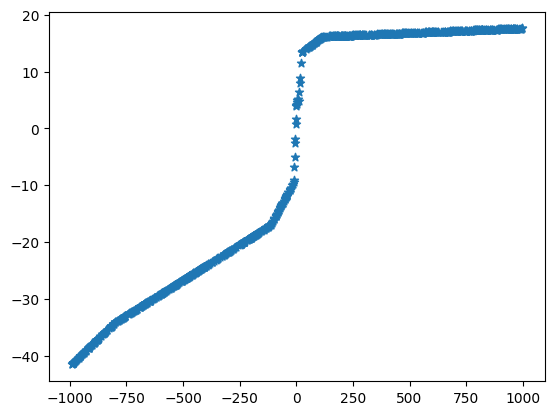

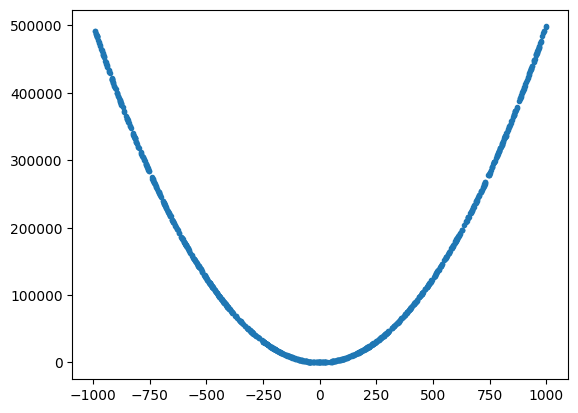

all done


In [12]:
model.eval()
y_pred = model(X2)
plt.scatter(X2[:,1].cpu().detach().numpy(),y_pred.cpu().detach().numpy(), marker='*')
# plt.scatter(X2[:,1],y_pred, marker='*')
plt.show()


plt.scatter(X2[:,1] ,y2, marker='.', )
plt.show()


print('all done')

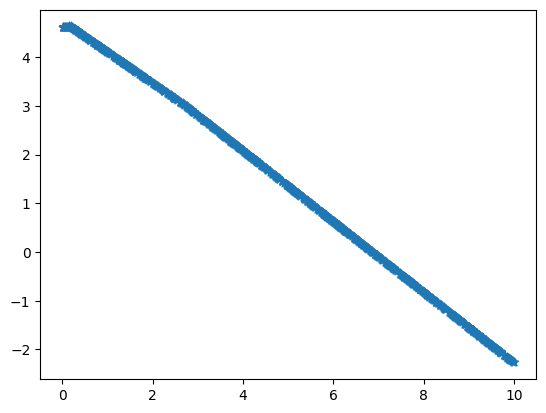

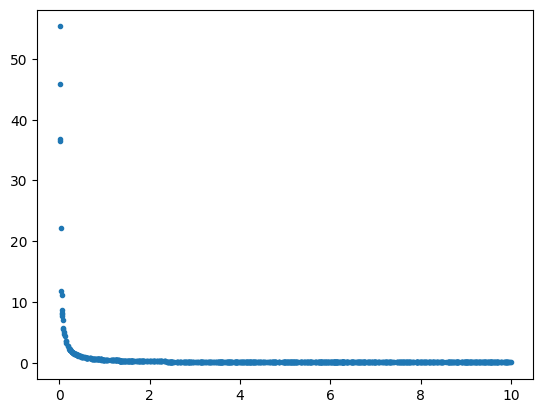

all done


In [13]:
model.eval()
y_pred = model(X3)
plt.scatter(X3[:,0].cpu().detach().numpy(),y_pred.cpu().detach().numpy(), marker='*')
# plt.scatter(X3[:,1],y_pred, marker='*')
plt.show()


plt.scatter(X3[:,0] ,y3, marker='.', )
plt.show()


print('all done')

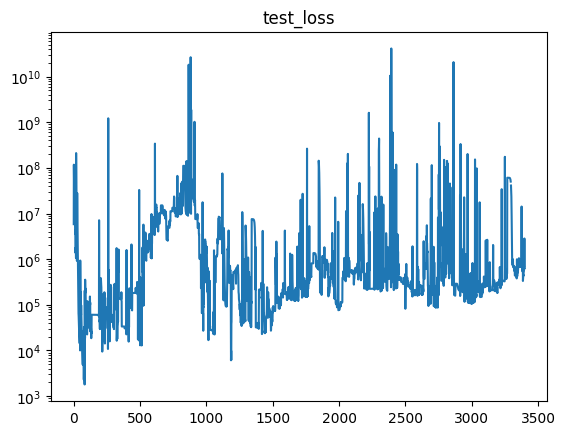

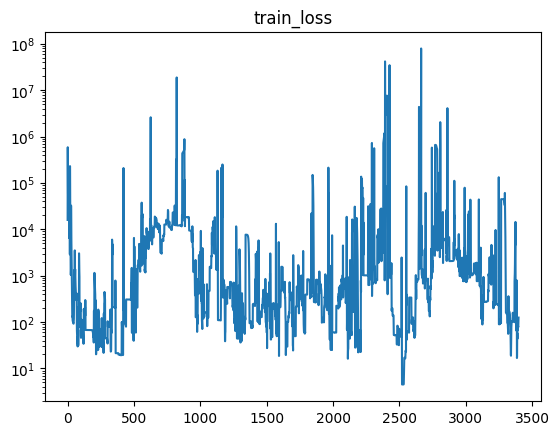

In [ ]:
plt.plot(history)
plt.yscale('log')
plt.title('test_loss')
plt.show()

plt.plot(history_train)
plt.title('train_loss')
plt.yscale('log')
plt.show()

In [ ]:
# when create new data

# N, D_in, H, D_out = 64, 1000, 100, 10
N, D_in, D_out = 100000, 2, 1

# 입력과 출력 위한 랜덤 텐서
X = []
y = []
for j in range(N):
    X.append([])
    #y.append([])
    for i in range(D_out):
        X[-1].append( np.random.uniform(low=0.0, high=1000.0, size=None) )
        X[-1].append( np.random.uniform(low=-1000.0, high=1000.0, size=None) )
        y.append( (X[-1][-1]**2) / (2*X[-1][-2])  )


X = torch.Tensor(X)
y = torch.Tensor(y)

# nn package를 이용하여 여러 층으로 정의된 모델 생성
# nn.Sequential은 다른 모듈을 담을 수 있는 모듈이며 담겨진 모듈은 순서대로 연결
# Linear 모듈은 곧 Affine 모듈

# Read data
# data = fetch_california_housing()
# X, y = data.data, data.target

# train-test split for model evaluation

import time
# >>> # Save to file
# >>> x = torch.tensor([0, 1, 2, 3, 4])
# >>> torch.save(x, 'tensor.pt')

torch.save(X, 'KEdataX_'+str(time.time())+'.pt' )
torch.save(y, 'KEdataY_'+str(time.time())+'.pt' )
